In [159]:
import numpy as np
import copy
import matplotlib
from matplotlib import pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from Data import CSVData

In [2]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

In [3]:
model_path = '/raid/projects/asinha15/VLQ-NN-Reweighting/trained_models/model_scripted6.pt'
model = torch.jit.load(model_path).to(device)
model.eval()

RecursiveScriptModule(
  original_name=Sequential
  (Linear0): RecursiveScriptModule(original_name=Linear)
  (Activation0): RecursiveScriptModule(original_name=LeakyReLU)
  (Linear1): RecursiveScriptModule(original_name=Linear)
  (Activation1): RecursiveScriptModule(original_name=LeakyReLU)
  (Linear2): RecursiveScriptModule(original_name=Linear)
  (Activation2): RecursiveScriptModule(original_name=LeakyReLU)
  (Linear_last): RecursiveScriptModule(original_name=Linear)
  (Activation_last): RecursiveScriptModule(original_name=LeakyReLU)
)

In [4]:
features = ['mode',
'Msim',
'Gsim',
'weight',
'pz_in1',
'pid_in1', 
'pz_in2',
'pid_in2',
'px_out1',
'py_out1',
'pz_out1',
'e_out1',
'pid_out1',
'px_out2',
'py_out2',
'pz_out2',
'e_out2',
'pid_out2',
'px_out3',
'py_out3',
'pz_out3',
'e_out3',
'pid_out3',
'px_out4',
'py_out4',
'pz_out4',
'e_out4',
'pid_out4',
'Mtarget',
'Gtarget',]
label = 'f_rwt'
features_to_rescale = ['Msim',
'Gsim',
'pz_in1', 
'pz_in2',
'px_out1',
'py_out1',
'pz_out1',
'e_out1',
'px_out2',
'py_out2',
'pz_out2',
'e_out2',
'px_out3',
'py_out3',
'pz_out3',
'e_out3',
'px_out4',
'py_out4',
'pz_out4',
'e_out4',
'Mtarget',
'Gtarget']

train_data = CSVData(batch_size=1024, features_name=features, labels_name=label, features_to_rescale= features_to_rescale, file_names=['/raid/projects/asinha15/train_' + str(i)+'.csv' for i in range(0,10)])

In [5]:
X, Y = train_data.load_data_many()
X = np.array(X)
Y = np.log(np.array(Y))

In [6]:
W = []
B = []
for name, param in model.named_parameters():
    if 'weight' in name:
        W.append(param.cpu().detach().numpy())
    elif 'bias' in name:
        B.append(param.cpu().detach().numpy())
L = len(W)

In [8]:
A = [X]+[None]*L
for l in range(L):
    A[l+1] = np.maximum(-0.1*A[l].dot(W[l].transpose())+B[l],A[l].dot(W[l].transpose())+B[l])

In [9]:
A

[array([[-1.00e+00,  1.70e+03,  8.50e+02, ...,  5.00e+00,  1.50e+03,
          4.50e+02],
        [-1.00e+00,  1.50e+03,  7.50e+02, ...,  5.00e+00,  1.60e+03,
          3.20e+02],
        [-1.00e+00,  1.10e+03,  2.75e+02, ...,  5.00e+00,  1.10e+03,
          3.85e+02],
        ...,
        [ 0.00e+00,  1.50e+03,  7.50e+02, ..., -5.00e+00,  1.70e+03,
          7.65e+02],
        [-1.00e+00,  2.10e+03,  1.05e+03, ..., -5.00e+00,  2.30e+03,
          5.75e+02],
        [-1.00e+00,  2.10e+03,  5.25e+02, ...,  5.00e+00,  2.20e+03,
          4.40e+02]]),
 array([[463.91074537, 122.75278745, 644.44703566, ..., 242.96898742,
          14.54749728, 192.35157338],
        [256.30337531, 575.26662507, 360.21038389, ..., 848.82687118,
         125.4747302 , 756.48022124],
        [465.53563747, 185.69655811, 260.06775837, ..., 211.86072546,
          19.81620564,  63.03280617],
        ...,
        [ 20.71645831, 501.98684633, 268.11325464, ..., 416.90061657,
          73.02754961, 577.06466531],


In [10]:
def rho(w,l):  
    return w + [None,0.1,0.0,0.0][l] * np.maximum(-0.1*w, w)
def incr(z,l): 
    return z + [None,0.0,0.1,0.0][l] * (z**2).mean()**.5+1e-9

In [33]:
R = [None]*L + [A[L]*[Y[:, None]]

In [34]:
R

[None,
 None,
 None,
 None,
 array([[-18.82924666],
        [ -4.95900532],
        [-14.73230769],
        ...,
        [-19.75736954],
        [-55.68436425],
        [-38.86032216]])]

In [35]:
for l in range(1,L)[::-1]:
    w = rho(W[l],l)
    b = rho(B[l],l)
    
    z = incr(A[l].dot(w.transpose())+b,l)    # step 1
    s = R[l+1] / z               # step 2
    try:
        c = s.dot(w.transpose())     # step 3
    except ValueError as e:
        c = s.dot(w)
    R[l] = A[l]*c                # step 4

In [37]:
# for the last layer which takes the features as inputs
w  = W[0]
wp = np.maximum(0,w)
wm = np.minimum(0,w)
lb = A[0]*0-1
hb = A[0]*0+1

z = A[0].dot(w.transpose())-lb.dot(wp.transpose())-hb.dot(wm.transpose())+1e-9        # step 1
s = R[1]/z                                        # step 2
c,cp,cm  = s.dot(w),s.dot(wp),s.dot(wm)          # step 3
R[0] = A[0]*c-lb*cp-hb*cm                         # step 4

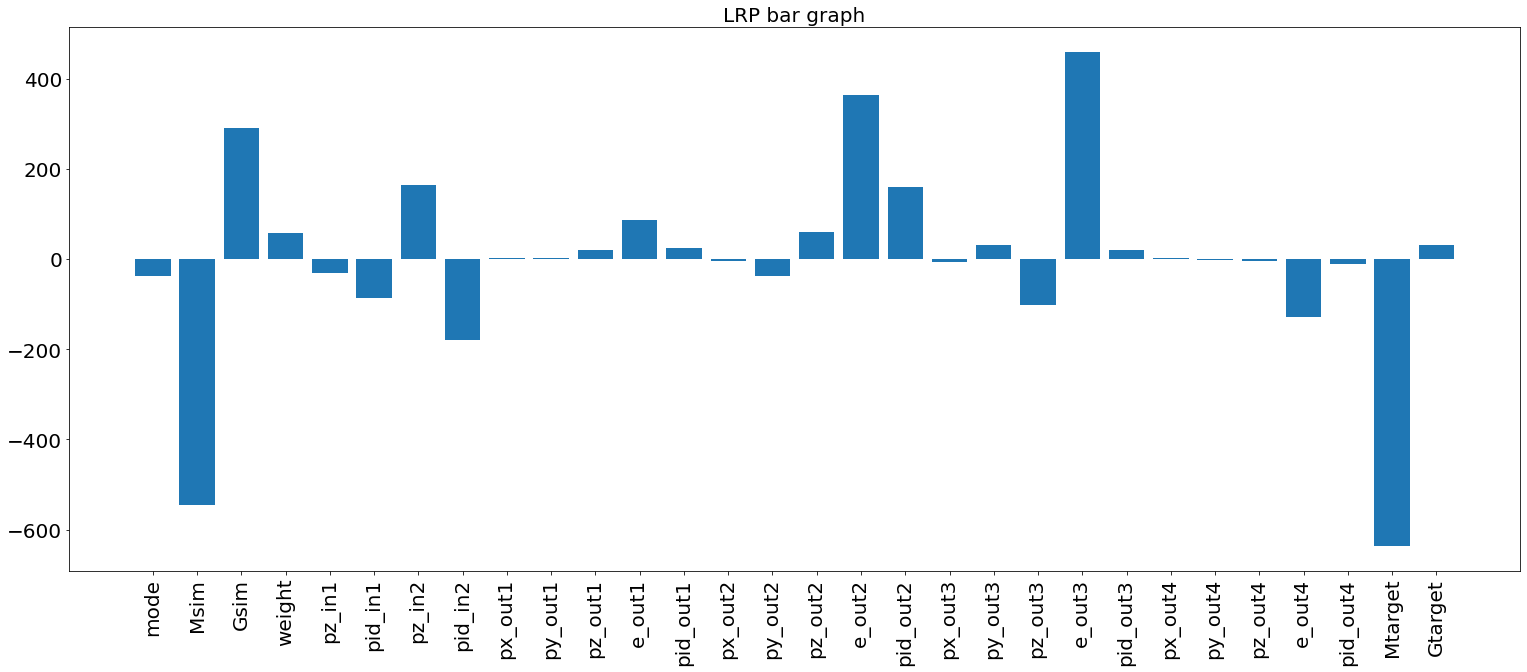

In [154]:
plt.rcParams["figure.figsize"] = (26,10)
plt.bar(features, np.mean(R[0], axis=0))
plt.xticks(features, features, rotation=90, size=20)
plt.yticks(size=20)
plt.title('LRP bar graph', size=20)
plt.show()

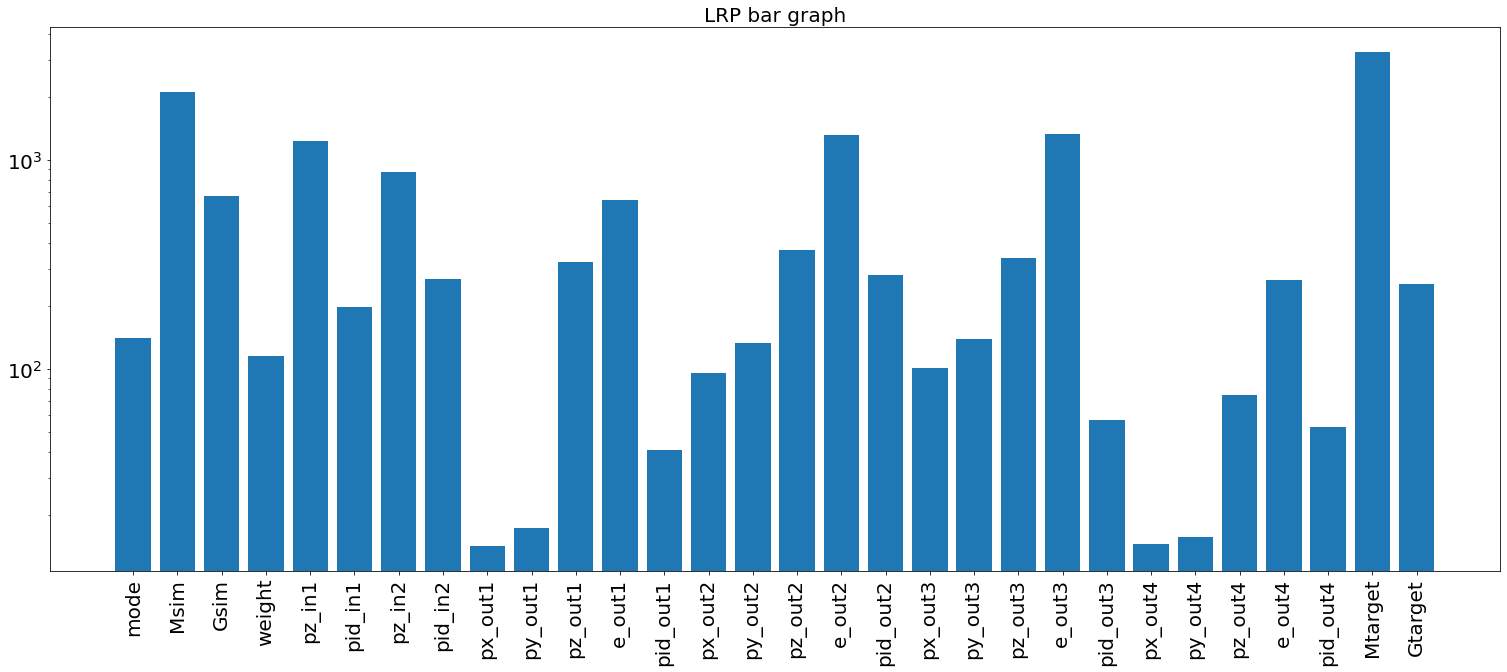

In [158]:
plt.rcParams["figure.figsize"] = (26,10)
plt.bar(features, np.mean(np.abs(R[0]), axis=0))
plt.yscale('log')
plt.xticks(features, features, rotation=90, size=20)
plt.yticks(size=20)
plt.title('LRP bar graph', size=20)
plt.show()

In [206]:
matplotlib.rcParams.update({'axes.titlesize': 'xx-large'})
plt.rcParams.update({'axes.labelsize': 'xx-large'})

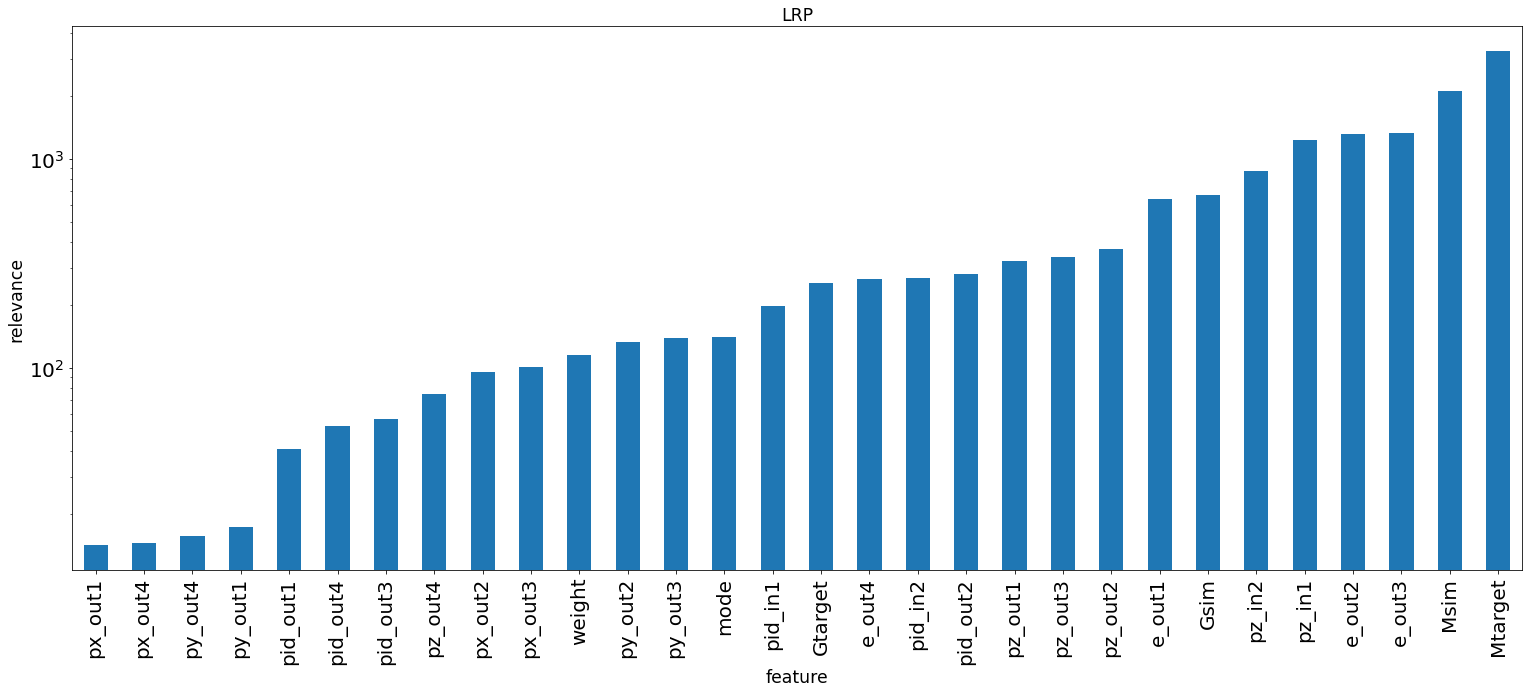

In [208]:
df = pd.DataFrame(np.array([features, np.mean(np.abs(R[0]), axis=0)]).transpose())
df.columns=['feature', 'relevance']
df.relevance = df.relevance.astype(float)
df = df.sort_values(by=['relevance'])
df.plot.bar(x='feature', y='relevance', legend=False, fontsize=20, logy=True, xlabel='feature', ylabel='relevance', title='LRP')
del df